### 霍夫变化

In [1]:
import sys
sys.path.append("../utils")
from imgload import *
import cv2
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import os
import math

%matplotlib inline
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False

#### 直线 圆检测

(<matplotlib.axes._subplots.AxesSubplot at 0x2a5d88b6550>,
 Text(0.5, 1.0, '圆形检测-霍夫变化'),
 (-0.5, 865.5, 550.5, -0.5))

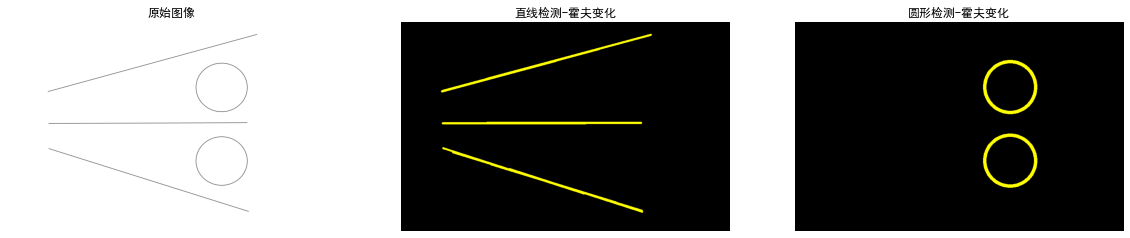

In [2]:
def simple_hough(cv2_img, dLine=True):
    zero_img = np.zeros((cv2_img.shape[0], cv2_img.shape[1],3), np.uint8)
    gray = cv2.cvtColor(cv2_img, cv2.COLOR_BGR2GRAY)
    edges = cv2.Canny(gray, 50, 150, apertureSize = 3)
    
    ###### 直线检测
    minLineLength,maxLineGap = 300, 2000 
    hough_outs = cv2.HoughLinesP(edges,1 , np.pi/180, 100, minLineLength= minLineLength, ### 直线检测
                            maxLineGap= maxLineGap)
    zero_img1 = zero_img.copy()
    for line in hough_outs:
        x1,y1,x2,y2 = line[0]
        cv2.line(zero_img1,(x1,y1),(x2,y2),(0,255,255), 4)
    
    #### 圆检测
    zero_img2 = zero_img.copy()
    hough_outs = cv2.HoughCircles(edges, cv2.HOUGH_GRADIENT,1, 100, param1=50, param2=30, 
                                  minRadius=20, maxRadius=0) ### 检测圆
    for i in hough_outs[0,:]:
        cx = int(i[0])
        cy = int(i[1])
        r = int(i[2])
        cv2.circle(zero_img2,(cx, cy), r, (0,255,255), 8 )
    
    return zero_img1, zero_img2

ori_img = cv2.imread("img/line.png")
m1, m2 = simple_hough(ori_img)
plt.figure(figsize=(20, 12))
plt.subplot(1,3,1), plt.imshow(ori_img[:,:,::-1]), plt.title('原始图像'), plt.axis('off')
plt.subplot(1,3,2), plt.imshow(m1[:,:,::-1]), plt.title('直线检测-霍夫变化'), plt.axis('off')
plt.subplot(1,3,3), plt.imshow(m2[:,:,::-1]), plt.title('圆形检测-霍夫变化'), plt.axis('off')

#### 图像纠偏

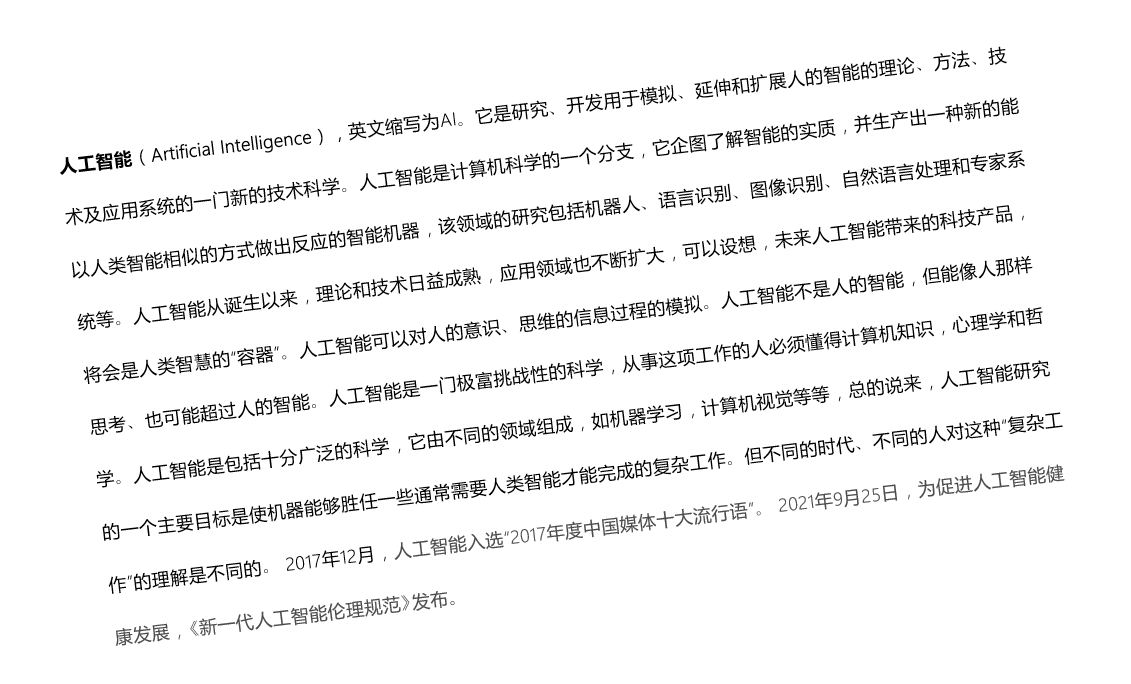

In [3]:
ori_img = cv2.imread('img/news1.png')
gray = cv2.cvtColor(ori_img, cv2.COLOR_BGR2GRAY)
cv2pil(gray)

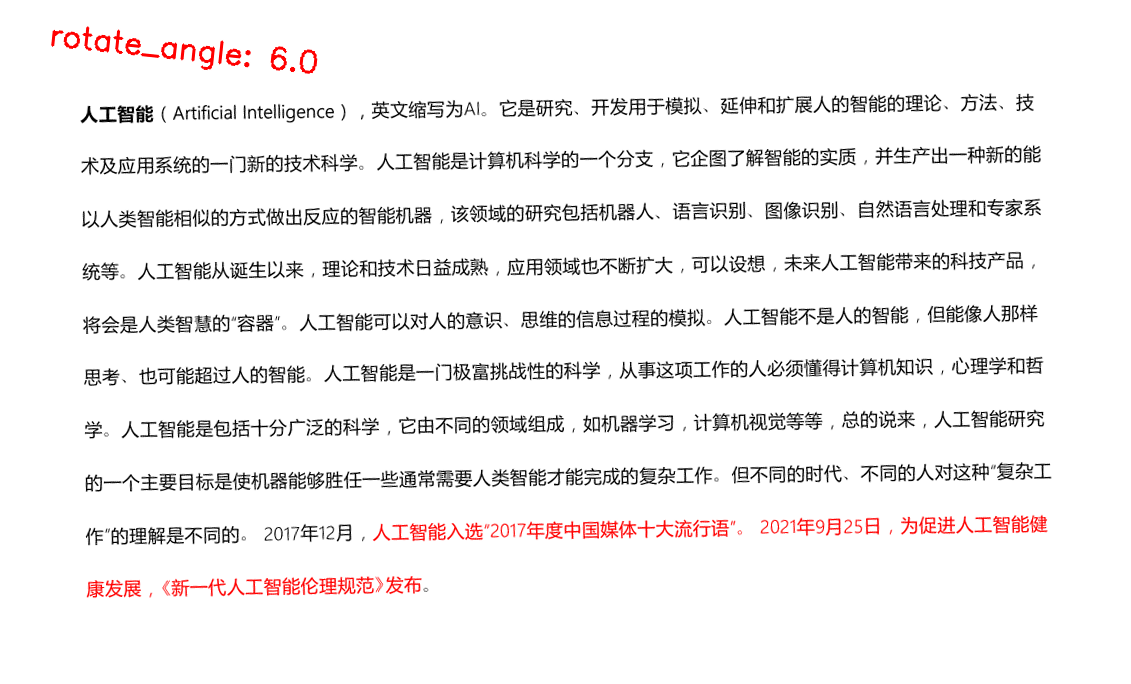

In [4]:

ori_img = cv2.imread('img/news1.png')
zero_img = np.zeros((ori_img.shape[0], ori_img.shape[1],3), np.uint8)
gray = cv2.cvtColor(ori_img, cv2.COLOR_BGR2GRAY)
edges = cv2.Canny(gray, 50, 100, apertureSize = 3)
lines = cv2.HoughLines(edges,1 , np.pi/180, 200, 0, 0)
h, w = ori_img.shape[:2]

for line in lines[0]:
    rho, theta = line
    a = np.cos(theta)
    b = np.sin(theta)
    x0 = a*rho
    y0 = b*rho
    x1 = int(x0 + 1000*(-b))
    y1 = int(y0 + 1000*(a))
    x2 = int(x0 - 1000*(-b))
    y2 = int(y0 - 1000*(a))
    
    t = float(y2-y1)/(x2-x1) ### 斜率
    rotate_angle = math.degrees(math.atan(t)) ### 角度计算
    rotate_angle = np.ceil(rotate_angle)
    

text = f"rotate_angle: {-rotate_angle}"
cv2.putText(ori_img, text, (20,100),  cv2.FONT_HERSHEY_SIMPLEX, 1, (0,0, 255), 2)

center = (w // 2, h // 2)
M = cv2.getRotationMatrix2D(center, rotate_angle, 1.0)  # 传入中心和角度，得到旋转矩形
rotated_img = cv2.warpAffine(ori_img, M, (w, h), flags=cv2.INTER_CUBIC, borderMode=cv2.BORDER_REPLICATE)  # 最后要换成原图


# plt.imshow(ori_img[:,:,::-1]),plt.title('原始图像'), plt.axis('off')
# plt.imshow(rotated_img[:,:,::-1]), plt.title('纠偏后的图像'),  plt.axis('off')
cv2pil(rotated_img)

### 水平集分割

(<matplotlib.axes._subplots.AxesSubplot at 0x2a5d86abac8>,
 Text(0.5, 1.0, 'ori_img结果'),
 (-0.5, 225.5, 282.5, -0.5))

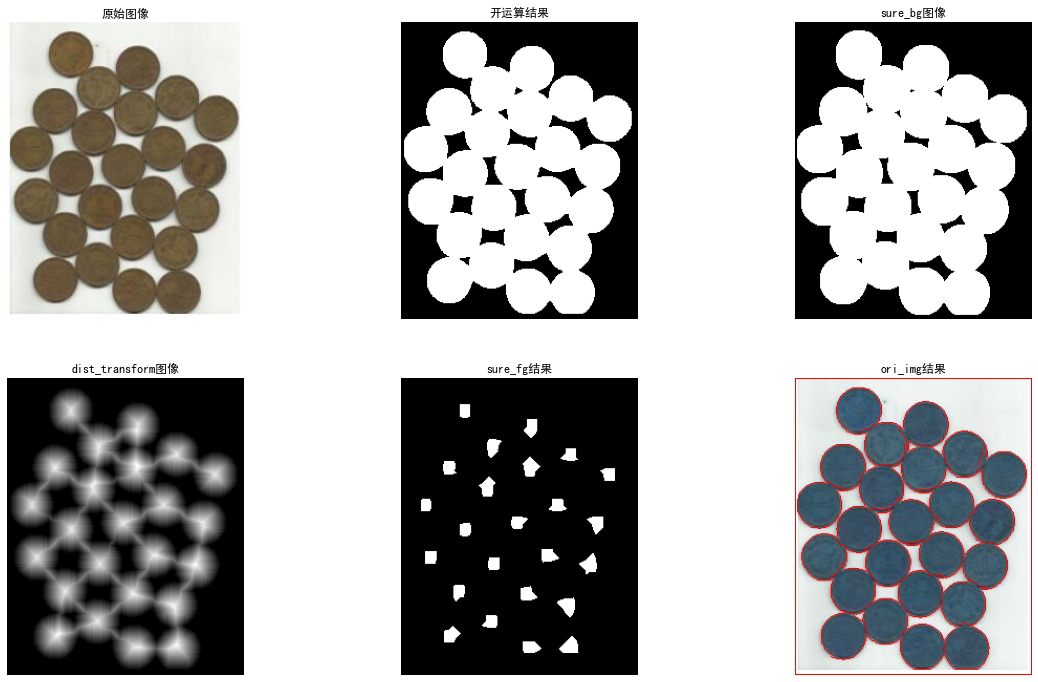

In [5]:

# url_path = 'https://img0.baidu.com/it/u=2285041519,537915980&fm=253&fmt=auto&app=138&f=JPEG?w=759&h=500'
# url_path = 'https://t7.baidu.com/it/u=2084624597,235761712&fm=193&f=GIF'
# ori_img = url2img(url_path)
ori_img = cv2.imread("img/1.jpg")
img = ori_img.copy()

gray = cv2.cvtColor(ori_img,cv2.COLOR_BGR2GRAY)
ret, thresh = cv2.threshold(gray,0,255,cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)

kernel = np.ones((3,3),np.uint8)
opening = cv2.morphologyEx(thresh,cv2.MORPH_OPEN,kernel, iterations = 2)
sure_bg = cv2.dilate(opening,kernel,iterations=1)
dist_transform = cv2.distanceTransform(opening,1,5)
ret, sure_fg = cv2.threshold(dist_transform,0.7*dist_transform.max(),255,0)

sure_fg = np.uint8(sure_fg)
unknown = cv2.subtract(sure_bg,sure_fg)

ret, markers1 = cv2.connectedComponents(sure_fg)
markers = markers1+1
markers[unknown==255] = 0
markers3 = cv2.watershed(ori_img,markers)
ori_img[markers3 == -1] = [255,0,0]


plt.figure(figsize=(20, 12))
plt.subplot(2,3,1), plt.imshow(img[:,:,::-1]),plt.title('原始图像'), plt.axis('off')
plt.subplot(2,3,2), plt.imshow(opening, 'gray'), plt.title('开运算结果'),  plt.axis('off')
plt.subplot(2,3,3), plt.imshow(sure_bg, 'gray'), plt.title('sure_bg图像'),  plt.axis('off')
plt.subplot(2,3,4), plt.imshow(dist_transform, 'gray'), plt.title('dist_transform图像'),  plt.axis('off')
plt.subplot(2,3,5), plt.imshow(sure_fg, 'gray'), plt.title('sure_fg结果'),  plt.axis('off')
plt.subplot(2,3,6), plt.imshow(ori_img, 'gray'), plt.title('ori_img结果'),  plt.axis('off')


In [ ]:
# Harris 角点检测


url_path = 'https://gimg2.baidu.com/image_search/src=http%3A%2F%2Fimg-blog.csdnimg.cn%2F20200115150919602.png%3Fx-oss-process%3Dimage%2Fwatermark%2Ctype_ZmFuZ3poZW5naGVpdGk%2Cshadow_10%2Ctext_aHR0cHM6Ly9ibG9nLmNzZG4ubmV0L1Rob21zb242MTc%3D%2Csize_16%2Ccolor_FFFFFF%2Ct_70&refer=http%3A%2F%2Fimg-blog.csdnimg.cn&app=2002&size=f9999,10000&q=a80&n=0&g=0n&fmt=auto?sec=1656512427&t=450ddc0cbe9457767eb52a62917aecab'
url_path = 'https://img2.baidu.com/it/u=2117250686,938423086&fm=253&fmt=auto&app=138&f=JPEG?w=640&h=480'
url_path = 'https://img1.baidu.com/it/u=2600488454,286252947&fm=253&fmt=auto&app=138&f=PNG?w=500&h=500'
# url_path = 'https://img2.baidu.com/it/u=2460064385,3979315867&fm=253&fmt=auto&app=138&f=JPEG?w=500&h=417'
ori_img = url2img(url_path)
img = ori_img.copy()
gray = cv2.cvtColor(ori_img,cv2.COLOR_BGR2GRAY)
gray = np.float32(gray) ### 转为浮点型
dst = cv2.cornerHarris(gray,2,3,0.04)
dst = cv2.dilate(dst,None)
img[dst>0.01*dst.max()]=[0,0,255]

plt.figure(figsize=(15, 12))
plt.subplot(121), plt.imshow(ori_img[:,:,::-1]),plt.title('原始图像'), plt.axis('off')
plt.subplot(122), plt.imshow(img[:,:,::-1], 'gray'), plt.title('角点检测结果'),  plt.axis('off')



In [ ]:
url_path = 'https://img1.baidu.com/it/u=2600488454,286252947&fm=253&fmt=auto&app=138&f=PNG?w=500&h=500'
ori_img = url2img(url_path)
# ori_img = cv2.imread('img/8.png')
img = ori_img.copy()
gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
gray = np.float32(gray)
dst = cv2.cornerHarris(gray,2,3,0.04)
dst = cv2.dilate(dst,None)
ret, dst = cv2.threshold(dst,0.01*dst.max(),255,0)
dst = np.uint8(dst)
ret, labels, stats, centroids = cv2.connectedComponentsWithStats(dst)

criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 100, 0.5)
corners = cv2.cornerSubPix(gray,np.float32(centroids),(5,5),(-1,-1),criteria)
res = np.hstack((centroids,corners))
res = np.int0(res)
img[res[:,1],res[:,0]]=[0,0,255]
img[res[:,3],res[:,2]] = [0,255,0]

cv2pil(img)

(<matplotlib.image.AxesImage at 0x2a5e19a9b38>,
 Text(0.5, 1.0, 'goodFeaturesToTrack检测结果'),
 (-0.5, 499.5, 499.5, -0.5))

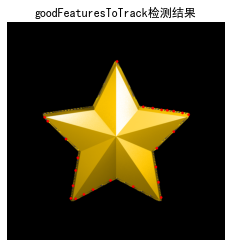

In [6]:
url_path = 'https://img1.baidu.com/it/u=2600488454,286252947&fm=253&fmt=auto&app=138&f=PNG?w=500&h=500'
ori_img = url2img(url_path)
img = ori_img.copy()

gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
corners = cv2.goodFeaturesToTrack(gray,25,0.01,10)
# 返回的结果是 [[ 311., 250.]] 两层括号的数组。
corners = np.int0(corners)
for i in corners:
    x,y = i.ravel()
    cv2.circle(img,(x,y),3,(0,0,255),-1)
plt.imshow(img[:,:,::-1]) ,plt.title("goodFeaturesToTrack检测结果"), plt.axis('off')

#### FAST SUB 无法使用需要重新安装opencv

In [ ]:

# url_path = 'https://img1.baidu.com/it/u=2600488454,286252947&fm=253&fmt=auto&app=138&f=PNG?w=500&h=500'
# ori_img = url2img(url_path)
# img = ori_img.copy()

# # surf = cv2.SURF(400)
# # # Find keypoints and descriptors directly
# # kp, des = surf.detectAndCompute(img,None)
# # print(f"关键点: {len(kp)}")

# fast = cv2.FastFeatureDetector()

# kp = fast.detect(img,None)
# img2 = cv2.drawKeypoints(img, kp, color=(255,0,0))


In [7]:
orb = cv2.ORB()

img1 = cv2.cvtColor(ori_img, cv2.COLOR_BGR2GRAY)
kp1, des1 = orb.detectAndCompute(img1,None)


error: Unknown C++ exception from OpenCV code